In [1]:
###### import requests
import json
import time
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy.random as rng

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [3]:
def viewAllDataFromFolder(dataPath):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        if ".pkl" in fs:
            count = count + 1
            dataItem = pd.read_pickle(dataPath+"/"+fs)
            dataItem["FileIndex"]=count
            dataList.append(dataItem)
    frame = pd.concat(dataList)
    frame = frame.reset_index().fillna(0)
#     frame["node"] = frame["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
    return (frame,count)

In [4]:
(dataset,filecount) = viewAllDataFromFolder("data5")

In [5]:
dataset

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,disk_space_used,net_received,net_transmit,node,label,FileIndex
0,1.635502e+09,0.000000,0.000000,0.000000,0.000000,10.0,194.49,2.862498e+09,1.223557e+09,0.000000,0.706717,0.000000e+00,0.000000e+00,tan-k3,1,1
1,1.635502e+09,0.000000,0.000000,0.000000,0.000000,10.0,194.49,2.862498e+09,1.223557e+09,0.000000,0.706717,0.000000e+00,0.000000e+00,tan-k3,1,1
2,1.635502e+09,0.155271,0.102959,0.721378,0.001666,10.0,211.56,2.862547e+09,1.223508e+09,0.031987,0.707104,4.011572e+06,3.802351e+05,tan-k3,1,1
3,1.635502e+09,0.155271,0.102959,0.721378,0.001666,10.0,211.56,2.862547e+09,1.223508e+09,0.031987,0.707104,4.011572e+06,3.802351e+05,tan-k3,1,1
4,1.635502e+09,0.178702,0.071014,0.735814,0.002000,10.0,198.31,2.852839e+09,1.233215e+09,0.069347,0.707250,1.134715e+06,6.488535e+05,tan-k3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210601,1.635604e+09,0.123667,0.179667,0.660000,0.000000,13.0,103.96,2.358104e+09,1.727939e+09,0.001333,0.758796,5.603547e+05,3.066001e+06,tan-k2,1,33
210602,1.635604e+09,0.122667,0.192667,0.668333,0.000333,13.0,107.90,2.358198e+09,1.727844e+09,0.004800,0.758797,2.623947e+05,2.293394e+06,tan-k2,1,33
210603,1.635604e+09,0.122667,0.192667,0.668333,0.000333,13.0,107.90,2.358198e+09,1.727844e+09,0.004800,0.758797,2.623947e+05,2.293394e+06,tan-k2,1,33
210604,1.635604e+09,0.132667,0.175000,0.667667,0.000000,13.0,131.07,2.358321e+09,1.727721e+09,0.002133,0.758798,5.716112e+05,3.118867e+06,tan-k2,1,33


In [6]:
dataset = dataset.fillna(0)
# dataset['timestamp'] = dataset['index']
dataset["timemm"] = dataset['timestamp']
dataset['timemm'] = dataset['timemm'].apply(lambda x: datetime.fromtimestamp(x))
dataset["year"] = dataset['timemm'].apply(lambda x:x.year)
dataset["month"] = dataset['timemm'].apply(lambda x:x.month)
dataset["day"] = dataset['timemm'].apply(lambda x:x.day)
dataset["hour"] = dataset['timemm'].apply(lambda x:x.hour)
dataset["minute"] = dataset['timemm'].apply(lambda x:x.minute)
dataset["second"] = dataset['timemm'].apply(lambda x:x.second)
del dataset['timemm']

dataset["node"] = dataset["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
dataset["cpu_total"] = 1 - dataset["cpu_idle"]

dataset["cpu_user_rate"] = dataset["cpu_user"] / dataset["cpu_total"]
dataset["cpu_system_rate"] = dataset["cpu_system"] / dataset["cpu_total"]

dataset["mem_used"] = dataset["mem_total"]
dataset["mem_total"] = dataset["mem_used"] + dataset["mem_avail"]

# dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
# dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]



# Labling

In [7]:
dataset["label"]=1

In [8]:
maliciousList3 = pd.read_csv('data5/malicious3.csv')

In [9]:
# maliciousList

In [10]:
for index, row in maliciousList3.iterrows():
    dataset.loc[(dataset["timestamp"] >= row['start']) & (dataset["timestamp"] <= row['end']) & (dataset["node"]==3), 'label'] = 0

In [11]:
maliciousList2 = pd.read_csv('data5/malicious2.csv')

for index, row in maliciousList2.iterrows():
    dataset.loc[(dataset["timestamp"] >= row['start']) & (dataset["timestamp"] <= row['end']) & (dataset["node"]==2), 'label'] = 0

## Label counts

In [12]:
dataset["label"].value_counts()

1    152084
0     58522
Name: label, dtype: int64

# Data overview

In [13]:
dataset

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,...,year,month,day,hour,minute,second,cpu_total,cpu_user_rate,cpu_system_rate,mem_used
0,1.635502e+09,0.000000,0.000000,0.000000,0.000000,10.0,194.49,4.086055e+09,1.223557e+09,0.000000,...,2021,10,29,10,0,16,1.000000,0.000000,0.000000,2.862498e+09
1,1.635502e+09,0.000000,0.000000,0.000000,0.000000,10.0,194.49,4.086055e+09,1.223557e+09,0.000000,...,2021,10,29,10,0,24,1.000000,0.000000,0.000000,2.862498e+09
2,1.635502e+09,0.155271,0.102959,0.721378,0.001666,10.0,211.56,4.086055e+09,1.223508e+09,0.031987,...,2021,10,29,10,0,32,0.897041,0.804175,0.173093,2.862547e+09
3,1.635502e+09,0.155271,0.102959,0.721378,0.001666,10.0,211.56,4.086055e+09,1.223508e+09,0.031987,...,2021,10,29,10,0,40,0.897041,0.804175,0.173093,2.862547e+09
4,1.635502e+09,0.178702,0.071014,0.735814,0.002000,10.0,198.31,4.086055e+09,1.233215e+09,0.069347,...,2021,10,29,10,0,48,0.928986,0.792061,0.192363,2.852839e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210601,1.635604e+09,0.123667,0.179667,0.660000,0.000000,13.0,103.96,4.086043e+09,1.727939e+09,0.001333,...,2021,10,30,14,18,24,0.820333,0.804551,0.150752,2.358104e+09
210602,1.635604e+09,0.122667,0.192667,0.668333,0.000333,13.0,107.90,4.086043e+09,1.727844e+09,0.004800,...,2021,10,30,14,18,32,0.807333,0.827828,0.151941,2.358198e+09
210603,1.635604e+09,0.122667,0.192667,0.668333,0.000333,13.0,107.90,4.086043e+09,1.727844e+09,0.004800,...,2021,10,30,14,18,40,0.807333,0.827828,0.151941,2.358198e+09
210604,1.635604e+09,0.132667,0.175000,0.667667,0.000000,13.0,131.07,4.086043e+09,1.727721e+09,0.002133,...,2021,10,30,14,18,48,0.825000,0.809293,0.160808,2.358321e+09


<AxesSubplot:xlabel='timestamp'>

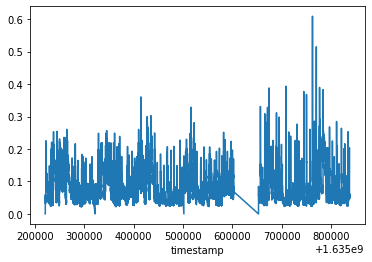

In [14]:
dataset[dataset["node"] == 3].sort_values(by=['timestamp']).set_index(["timestamp"])["cpu_system"].plot()

In [15]:
def plotColor(dataset, node, metric,startTime,endTime, ax,locX,locY):
#     node=3
#     metric = "cpu_system"
    refDataset = dataset[(dataset["node"] == node) & (dataset["timestamp"]>=startTime) & (dataset["timestamp"]<=endTime) ].copy()
    refDataset = refDataset.sort_values(by=['timestamp']).set_index(["timestamp"])
    df = refDataset[[metric,"label"]]
    df["label"] = df["label"].apply(lambda x : -1 if x==0 else 1)
    def plot_func(group):
    #     print(group['cpu_system'])
#         global ax
#         global locX
#         global locY
        color = 'r' if (group['label'] < 0).all() else 'g'
        lw = 1.0
        ax[locX,locY].plot(group.index, group[metric], c=color, linewidth=lw)

    df.groupby((df['label'].shift() * df['label'] < 0).cumsum()).apply(plot_func)
    ax[locX,locY].set_title(metric)

# add ma lines
# ax.plot(df.index, df['cpu_system'], 'k--', label='MA-50')
# ax.plot(df.index, df['200dma'], 'b--', label='MA-200')
# ax.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

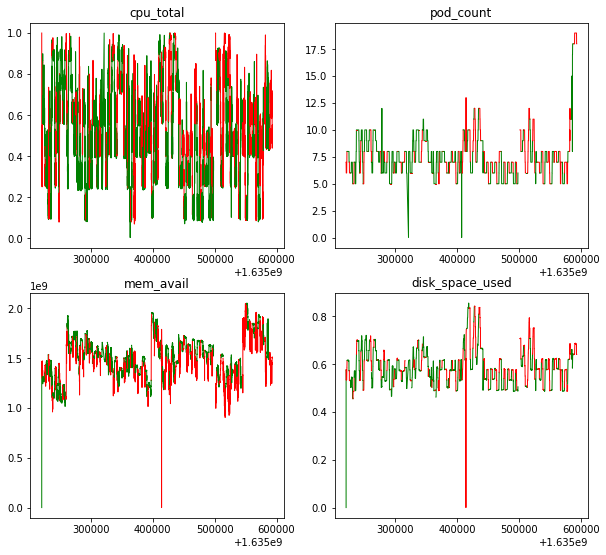

In [16]:
node=3
startTime = 1635079051
endTime = 1635593228
metricLs = ["cpu_total","pod_count","mem_avail","disk_space_used"]
divident = 2
xlen = len(metricLs)

xc = xlen % divident
if xc > 0 :
    xc = int(xlen / divident) + 1
else :
    xc = int(xlen / divident)
yc = divident
    
fig, axs = plt.subplots(xc, yc)
plt.subplots_adjust(top=1.5,wspace=0.2,hspace=0.2)
fig.set_size_inches(10, 5, forward=True)

for i in range(0,xlen):
    locX = int(i/divident)
    locY = i%divident
    plotColor(dataset, node, metricLs[i],startTime,endTime, axs, locX,locY)
# plotColor(dataset, node, "cpu_total",startTime,endTime, axs, 0,1)

<AxesSubplot:>

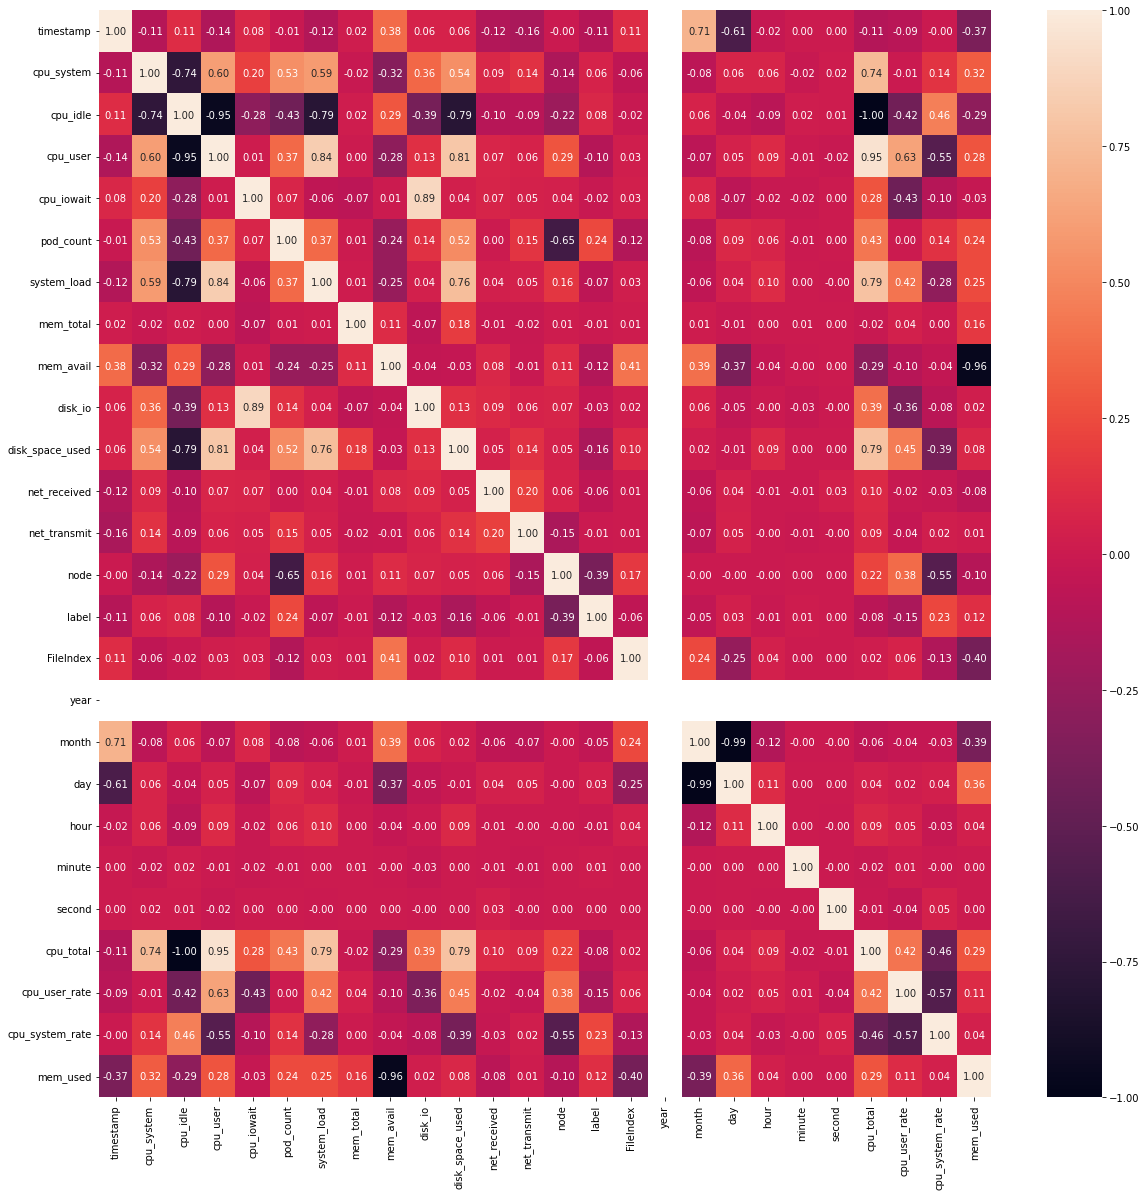

In [17]:
# !pip3 install imblearn
import seaborn as sn
plt.figure(figsize=(20,20))
sn.heatmap(dataset.corr(), annot=True, fmt='.2f')

# Select attributes

In [18]:
dataToRun = dataset[['cpu_system','cpu_idle','cpu_user','cpu_iowait','pod_count','system_load','mem_avail','disk_io','disk_space_used','net_received','net_transmit','year','month','day','hour','minute','second','cpu_total','cpu_user_rate','cpu_system_rate','mem_used','label']].copy()
dataToRun["label"].value_counts()

1    152084
0     58522
Name: label, dtype: int64

## Resample data

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.preprocessing import StandardScaler
import pickle

In [20]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

In [21]:
rsDataset = resampleData(dataToRun, "label")

In [22]:
# rsDataset=pd.read_pickle("tmp/rsDataset.pkl")
rsDataset.to_pickle("tmp/rsDataset.pkl")

In [23]:
def splitDataSetSKLearn(dataAllX, dataAllY, testSplitPercent):
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    print("splitDataSet with sklearn")
    print("Train")
    print(X_train.shape)
    print("Train labels")
    print(y_train.value_counts())
    print("Test")
    print(X_test.shape)
    print("Test labels")
    print(y_test.value_counts())
    print("All")
    print(dataAllX.shape)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)
# splitDataSetSKLearn(nDatasetNormKnn,70)

In [24]:
dataAllXOrigin = rsDataset.drop("label", axis=1)
dataAllYOrigin = rsDataset["label"]

In [25]:
scaler = StandardScaler()
dataAllXNorm = scaler.fit_transform(dataAllXOrigin)
# dataAllXNorm= dataAllXNorm.fillna(0)
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [26]:
# with open('tmp/dataAllXNorm.pkl','rb') as f: dataAllXNorm = pickle.load(f)
with open('tmp/dataAllXNorm.pkl','wb') as f: pickle.dump(dataAllXNorm, f)

# dataAllYOrigin=pd.read_pickle("tmp/dataAllYOrigin.pkl")
dataAllYOrigin.to_pickle("tmp/dataAllYOrigin.pkl")

In [27]:
(dataAllX, dataAllY, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(dataAllXNorm,dataAllYOrigin, 0.2)


splitDataSet with sklearn
Train
(243334, 21)
Train labels
0    121674
1    121660
Name: label, dtype: int64
Test
(60834, 21)
Test labels
1    30424
0    30410
Name: label, dtype: int64
All
(304168, 21)


# XGBoost

In [104]:
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')
modelXGboost.fit(dataTrainMX, dataTrainMY)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:34] WARNING: /tmp/pip-build-gl796k9i/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=6, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [105]:
start_time = time.time()
y_pred = modelXGboost.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))
print("XGBoost Prediction Time:",(time.time() - start_time))
timeXGBoostPrediction = time.time() - start_time

Accuracy score: 0.7959364828878588
XGBoost Prediction Time: 0.05064821243286133


In [30]:
featureList = list(dataAllXOrigin.columns.values)
featureList

['cpu_system',
 'cpu_idle',
 'cpu_user',
 'cpu_iowait',
 'pod_count',
 'system_load',
 'mem_avail',
 'disk_io',
 'disk_space_used',
 'net_received',
 'net_transmit',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'cpu_total',
 'cpu_user_rate',
 'cpu_system_rate',
 'mem_used']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

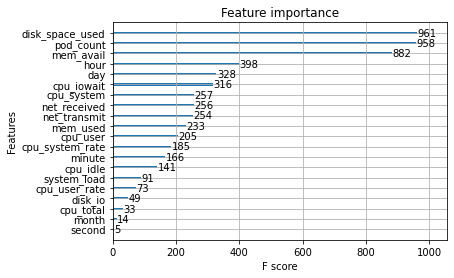

In [31]:
modelXGboost.get_booster().feature_names = featureList
xgboost.plot_importance(modelXGboost.get_booster())

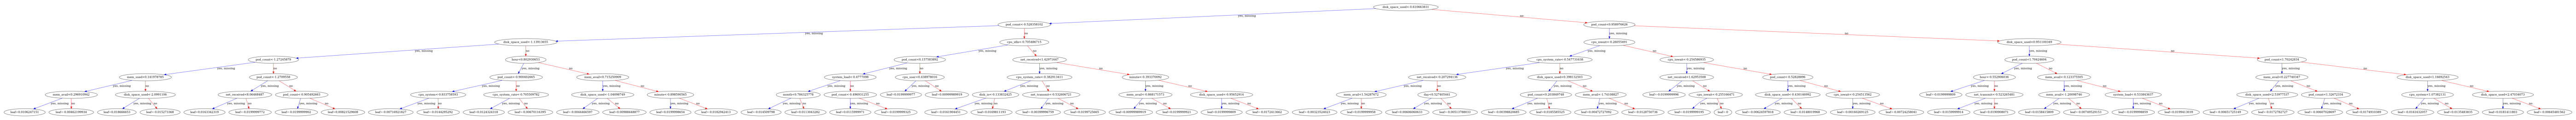

In [32]:
fig, ax = plt.subplots(figsize=(100, 100))
xgboost.plot_tree(modelXGboost, num_trees=10, ax=ax)
plt.show()

# XGBoost KFold

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

In [39]:
start_time = time.time()
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelXGboost, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
# force scores to be positive
print("XGBoost Training Time:",(time.time() - start_time))
timeXGBoost = time.time() - start_time

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


XGBoost Training Time: 735.0166988372803


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.2min finished


In [40]:
scores = absolute(scores)
print('Mean score: %.3f (%.3f)' % (scores.mean(), scores.std()) )
scoresXGBoostMean = scores.mean()

Mean score: 0.795 (0.002)


# KNN

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.model_selection import cross_val_score

In [107]:
from sklearn.neighbors import KNeighborsClassifier
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelKNN.fit(dataTrainMX, dataTrainMY)
# KNeighborsClassifier(...)
# print(neigh.predict([[1.1]]))

KNeighborsClassifier(n_neighbors=3)

In [108]:
start_time = time.time()
y_pred = modelKNN.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))
print("KNN Prediction Time:",(time.time() - start_time))
timeKNNPrediction = time.time() - start_time

Accuracy score: 0.9437321234835783
KNN Prediction Time: 190.33372569084167


In [44]:
start_time = time.time()
modelKNN = KNeighborsClassifier(n_neighbors=3)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresKNN = cross_val_score(modelKNN, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=3)
# force scores to be positive
print("KNN Training Time:",(time.time() - start_time))
timeKNN = time.time() - start_time

KNN Training Time: 1715.270762205124


In [45]:
scoresKNN = absolute(scoresKNN)
print('Mean score: %.3f (%.3f)' % (scoresKNN.mean(), scoresKNN.std()) )
scoresKNNMean = scoresKNN.mean()

Mean score: 0.946 (0.001)


# Decision Tree

In [109]:
from sklearn import tree

modelDT = tree.DecisionTreeClassifier(max_depth=10)
modelDT = modelDT.fit(dataTrainMX, dataTrainMY)

In [110]:
start_time = time.time()
y_pred = modelDT.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))
print("DT Prediction Time:",(time.time() - start_time))
timeDTPrediction = time.time() - start_time

Accuracy score: 0.8218430482953611
DT Prediction Time: 0.014195680618286133


In [48]:
start_time = time.time()
modelDT = tree.DecisionTreeClassifier(max_depth=10)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresDT = cross_val_score(modelDT, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=3)
# force scores to be positive
print("DT Training Time:",(time.time() - start_time))
timeDT = time.time() - start_time

DT Training Time: 53.26205492019653


In [49]:
scoresDT = absolute(scoresDT)
print('Mean score: %.3f (%.3f)' % (scoresDT.mean(), scoresDT.std()) )
scoresDTMean = scoresDT.mean()

Mean score: 0.829 (0.003)


# RandomForestClassifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
modelRF = RandomForestClassifier(max_depth=10, random_state=0)
modelRF.fit(dataTrainMX, dataTrainMY)

RandomForestClassifier(max_depth=10, random_state=0)

In [112]:
start_time = time.time()
y_pred = modelRF.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))
print("DT Prediction Time:",(time.time() - start_time))
timeRFPrediction = time.time() - start_time

Accuracy score: 0.8468455140217641
DT Prediction Time: 0.6165859699249268


## RandomForestClassifier KFold

In [53]:
start_time = time.time()
modelRF = RandomForestClassifier(max_depth=10, random_state=0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresRF = cross_val_score(modelRF, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=3)
# force scores to be positive
print("RF Training Time:",(time.time() - start_time))
timeRF = time.time() - start_time

RF Training Time: 698.5334522724152


In [54]:
scoresRF = absolute(scoresRF)
print('Mean score: %.3f (%.3f)' % (scoresRF.mean(), scoresRF.std()) )
scoresRFMean = scoresRF.mean()

Mean score: 0.848 (0.002)


# ADA Boost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

In [114]:
modelAda = AdaBoostClassifier()

modelAda.fit(dataTrainMX, dataTrainMY)

AdaBoostClassifier()

In [115]:
start_time = time.time()
y_pred = modelAda.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))
print("Ada Prediction Time:",(time.time() - start_time))
timeAdaPrediction = time.time() - start_time

Accuracy score: 0.7752572574547129
Ada Prediction Time: 0.5110049247741699


## ADA Boost KFold

In [96]:
start_time = time.time()
modelAda = AdaBoostClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresAda = cross_val_score(modelAda, dataAllX, dataAllY, scoring='accuracy', cv=cv, n_jobs=3)
# force scores to be positive
print("Ada boost Training Time:",(time.time() - start_time))
timeAda = time.time() - start_time

Ada boost Training Time: 375.4124331474304


In [99]:
# scoresAda

In [98]:
scoresAda = absolute(scoresAda)
print('Mean score: %.3f (%.3f)' % (scoresAda.mean(), scoresAda.std()) )
scoresAdaMean = scoresAda.mean()

Mean score: 0.772 (0.003)


# ANN

In [60]:
rsDataset

,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_avail,disk_io,disk_space_used,net_received,...,month,day,hour,minute,second,cpu_total,cpu_user_rate,cpu_system_rate,mem_used,label
0,0.000000,0.000000,0.000000,0.000000,10.000000,194.490000,1.223557e+09,0.000000,0.706717,0.000000e+00,...,10,29,10,0,16,1.000000,0.000000,0.000000,2.862498e+09,0
1,0.000000,0.000000,0.000000,0.000000,10.000000,194.490000,1.223557e+09,0.000000,0.706717,0.000000e+00,...,10,29,10,0,24,1.000000,0.000000,0.000000,2.862498e+09,0
2,0.155271,0.102959,0.721378,0.001666,10.000000,211.560000,1.223508e+09,0.031987,0.707104,4.011572e+06,...,10,29,10,0,32,0.897041,0.804175,0.173093,2.862547e+09,0
3,0.155271,0.102959,0.721378,0.001666,10.000000,211.560000,1.223508e+09,0.031987,0.707104,4.011572e+06,...,10,29,10,0,40,0.897041,0.804175,0.173093,2.862547e+09,0
4,0.178702,0.071014,0.735814,0.002000,10.000000,198.310000,1.233215e+09,0.069347,0.707250,1.134715e+06,...,10,29,10,0,48,0.928986,0.792061,0.192363,2.852839e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304163,0.078648,0.444666,0.450293,0.000241,10.554465,37.306616,1.571264e+09,0.001600,0.680419,2.738218e+05,...,10,28,14,33,0,0.555334,0.807091,0.140815,2.514779e+09,0
304164,0.047830,0.682577,0.231213,0.000694,9.000000,2.130334,2.013496e+09,0.001442,0.616711,2.621451e+05,...,11,1,2,34,6,0.317423,0.728280,0.150683,2.072547e+09,0
304165,0.055779,0.576405,0.332665,0.004484,7.000000,16.543698,1.435911e+09,0.043761,0.630853,1.114961e+06,...,11,1,14,14,51,0.423595,0.785350,0.131677,2.650144e+09,0
304166,0.042876,0.840137,0.097505,0.000834,8.000000,0.779878,1.762221e+09,0.005381,0.569429,2.428812e+05,...,10,28,19,30,34,0.159863,0.609556,0.268462,2.323821e+09,0


In [61]:
# normData = normalizeColumn(rsDataset,0,21)
# normData= normData.fillna(0)
# normData
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(rsDataset, 0.3)


In [62]:
# normData=pd.read_pickle("tmp/normData.pkl")
# normData.to_pickle("tmp/normData.pkl")

In [68]:
np.array(dataTrainMX).shape

(243334, 21)

In [72]:
X_train_ann = np.array(dataTrainMX).reshape((dataTrainMX.shape[0],dataTrainMX.shape[1],1))
X_test_ann = np.array(dataTestMX).reshape((dataTestMX.shape[0],dataTestMX.shape[1],1))
Y_train_ann = np.array(dataTrainMY).reshape((dataTrainMY.shape[0],1))
Y_test_ann = np.array(dataTestMY).reshape((dataTestMY.shape[0],1))
print("Data Shape:",X_train_ann.shape," ",Y_train_ann.shape)

Data Shape: (243334, 21, 1)   (243334, 1)


In [73]:
modelANN = keras.Sequential()
modelANN.add(Dense(units=10,input_shape=(X_train_ann.shape[1],X_train_ann.shape[2]),activation='relu'))  
modelANN.add(Dense(units=5,activation='sigmoid')) 
# modelANN.add(Dense(units=3,activation='sigmoid')) 
modelANN.add(keras.layers.Flatten())
modelANN.add(Dense(units=50, activation='sigmoid')) #output layer   
modelANN.add(Dense(units=1, activation='sigmoid')) #output layer   

In [74]:
modelANN.summary()
# keras.utils.plot_model(model, "ann.png", show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 21, 10)            20        
_________________________________________________________________
dense_5 (Dense)              (None, 21, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 105)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5300      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 5,426
Trainable params: 5,426
Non-trainable params: 0
_________________________________________________________________


In [75]:
# model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
start_time = time.time()

# modelANN.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
modelANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = modelANN.fit(X_train_ann, Y_train_ann, epochs=100, validation_split = 0.1)

print("ANN Training Time:",(time.time() - start_time))

Epoch 1/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.5100 - accuracy: 0.7262 - val_loss: 0.4752 - val_accuracy: 0.7449
Epoch 2/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.4575 - accuracy: 0.7607 - val_loss: 0.4519 - val_accuracy: 0.7533
Epoch 3/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.4319 - accuracy: 0.7783 - val_loss: 0.4242 - val_accuracy: 0.7840
Epoch 4/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.4136 - accuracy: 0.7907 - val_loss: 0.4060 - val_accuracy: 0.7973
Epoch 5/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.3984 - accuracy: 0.8007 - val_loss: 0.3863 - val_accuracy: 0.8117
Epoch 6/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.3833 - accuracy: 0.8113 - val_loss: 0.3727 - val_accuracy: 0.8192
Epoch 7/100
6844/6844 [==============================] - 11s 2ms/step - loss: 0.3689 - accuracy: 0.8204 - val_loss: 0.3607 -

In [116]:
start_time = time.time()
y_pred = modelANN.predict(X_test_ann)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print("Accuracy score:",accuracy_score(Y_test_ann, y_pred))
print("ANN Prediction Time:",(time.time() - start_time))
timeANNPrediction = time.time() - start_time

Accuracy score: 0.9503073938915738
ANN Prediction Time: 1.3486099243164062


In [79]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


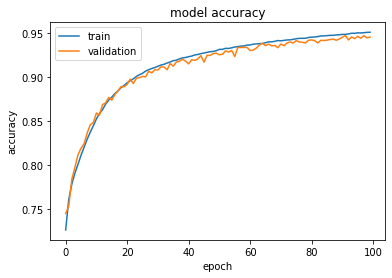

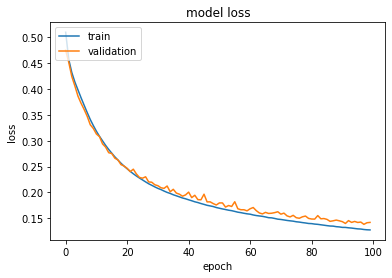

In [80]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [84]:
# dataAllX = normData.drop("label", axis=1)
# dataAllY = normData["label"]

dataAllX_ann = np.array(dataAllX).reshape((dataAllX.shape[0],dataAllX.shape[1],1))
dataAllY_ann = np.array(dataAllY).reshape((dataAllY.shape[0],1))

In [85]:
# n_split = 10
# for train_index,test_index in KFold(n_split).split(dataAllX_ann):
#     x_train,x_test=dataAllX_ann[train_index],dataAllX_ann[test_index]
#     y_train,y_test=dataAllX_ann[train_index],dataAllX_ann[test_index]

In [86]:
# dataAllY_ann

In [87]:
start_time = time.time()

kfold = KFold(n_splits=10, shuffle=True)
lsAnnAcc = []

for train_index,test_index in kfold.split(dataAllX_ann):
    x_train,x_test=dataAllX_ann[train_index],dataAllX_ann[test_index]
    y_train,y_test=dataAllY_ann[train_index],dataAllY_ann[test_index]
    
    modelANN = keras.Sequential()
    modelANN.add(Dense(units=10,input_shape=(X_train_ann.shape[1],X_train_ann.shape[2]),activation='relu'))  
    modelANN.add(Dense(units=5,activation='sigmoid')) 
    # modelANN.add(Dense(units=3,activation='sigmoid')) 
    modelANN.add(keras.layers.Flatten())
    modelANN.add(Dense(units=50, activation='sigmoid')) #output layer   
    modelANN.add(Dense(units=1, activation='sigmoid')) #output layer   
      
    modelANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = modelANN.fit(x_train, y_train, epochs=100, validation_split = 0.2)

    y_pred = modelANN.predict(x_test)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy score:",acc)
    
    lsAnnAcc.append(acc)
    
print("ANN Training Time:",(time.time() - start_time))
timeANN = time.time() - start_time

Epoch 1/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.5083 - accuracy: 0.7000 - val_loss: 0.7889 - val_accuracy: 0.4377
Epoch 2/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.4566 - accuracy: 0.7384 - val_loss: 0.4584 - val_accuracy: 0.8143
Epoch 3/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.4257 - accuracy: 0.7654 - val_loss: 0.5122 - val_accuracy: 0.7453
Epoch 4/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.4036 - accuracy: 0.7819 - val_loss: 0.4934 - val_accuracy: 0.7622
Epoch 5/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.3856 - accuracy: 0.7974 - val_loss: 0.5401 - val_accuracy: 0.7093
Epoch 6/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.3679 - accuracy: 0.8115 - val_loss: 0.3633 - val_accuracy: 0.8705
Epoch 7/100
6844/6844 [==============================] - 12s 2ms/step - loss: 0.3523 - accuracy: 0.8240 - val_loss: 0.3569 -

In [88]:
lsAnnAcc = np.array(lsAnnAcc)
print('Mean ANN MAE: %.3f (%.3f)' % (lsAnnAcc.mean(), lsAnnAcc.std()) )
scoresANNMean = lsAnnAcc.mean()

Mean ANN MAE: 0.941 (0.005)


In [89]:
# kfold = KFold(n_splits=10, shuffle=True)
# lsAnnMSE = []
# for train, test in kfold.split(dataAllX_ann, dataAllY_ann):
#     print(train)

# Comparision

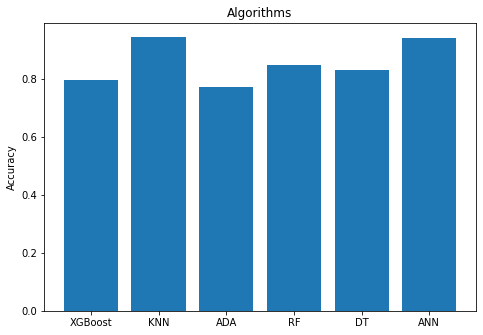

In [120]:
# cpd = pd.DataFrame([])
# scoresXGBoostMean = 0.82
# scoresKNNMean = 0.90
# scoresANNMean =0.95
algorithm =  ["XGBoost", "KNN","ADA","RF","DT","ANN"]
mseList = [scoresXGBoostMean, scoresKNNMean,scoresAdaMean,scoresRFMean,scoresDTMean, scoresANNMean]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(algorithm, mseList)
plt.ylabel("Accuracy")
plt.title('Algorithms')
plt.show()



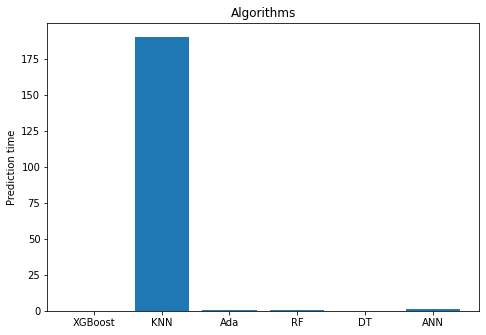

In [123]:
# cpd = pd.DataFrame([])
algorithm =  ["XGBoost", "KNN","Ada","RF","DT","ANN"]
mseList = [timeXGBoostPrediction, timeKNNPrediction,timeAdaPrediction, timeRFPrediction, timeDTPrediction ,timeANNPrediction]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(algorithm, mseList)
plt.ylabel("Prediction time")
plt.title('Algorithms')
plt.show()



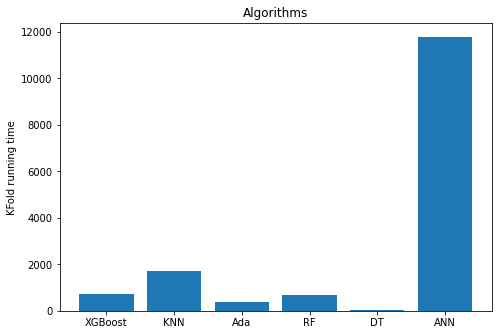

In [122]:
# cpd = pd.DataFrame([])
algorithm =  ["XGBoost", "KNN","Ada","RF","DT","ANN"]
mseList = [timeXGBoost, timeKNN,timeAda, timeRF, timeDT ,timeANN]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(algorithm, mseList)
plt.ylabel("KFold running time")
plt.title('Algorithms')
plt.show()



In [92]:
# train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(modelDT, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                    scoring="neg_mean_squared_error", cv=10)
# train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(modelLR, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                    scoring="neg_mean_squared_error", cv=10)

# train_sizes_krr, train_scores_krr, test_scores_krr = learning_curve(modelKRR, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                    scoring="neg_mean_squared_error", cv=10)

# train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(modelSVM, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                    scoring="neg_mean_squared_error", cv=10)

# train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(modelKNN, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                    scoring="neg_mean_squared_error", cv=10)

# #train_sizes_ann, train_scores_ann, test_scores_ann = learning_curve(modelANN, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
# #                   scoring="neg_mean_squared_error", cv=10)

# plt.plot(train_sizes_dt, -test_scores_dt.mean(1), 'o-', color="pink", label="DT")
# plt.plot(train_sizes_lr, -test_scores_lr.mean(1), 'o-', color="yellow", label="LR")
# plt.plot(train_sizes_krr, -test_scores_krr.mean(1), 'o-', color="green", label="KRR")
# plt.plot(train_sizes_svm, -train_scores_svm.mean(1), 'o-', color="red", label="SVM")
# plt.plot(train_sizes_knn, -train_scores_knn.mean(1), 'o-', color="blue", label="KNN")

# plt.xlabel("Train size")
# plt.ylabel("Mean Squared Error")
# plt.title('Learning curves')
# plt.legend(loc="best")

# plt.show()